`5/6 Jan 2018 -- WNixalo`

# Loading Individual Test Data From Array -- Visualization

## Pipeline

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai_osx.model import resnet34
from fastai_osx.conv_learner import *

In [10]:
PATH = 'data/'

def get_image_ndarray(path='data/train/'):
    """Returns a random image as an ndarray in an ndarray from the GLOC Dataset"""
    # get random image
    if '.DS_Store' in os.listdir(path):
        os.remove(tpath + '.DS_Store')
    folders = os.listdir(path)
    folder  = np.random.choice(folders)
    fname   = np.random.choice(os.listdir(path+folder))
    fpath   = path+folder+'/'+fname; fpath

    # load image as ndarray
    image = cv2.imread(fpath) # dtype = 'uint8'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB conversion

    # reshape image to PyTorch Tensor Order: (Channel,H,W)
    # image = np.rollaxis(image, 2, 0)

    # return image as ndarray of ndarrays, and image filepath
    return np.array([image]), fpath

In [13]:
# get random test image and dummy train/val image & label
img_ndarray, fpath = get_image_ndarray()

train_dat = img_ndarray, np.array([1])
val_dat = train_dat

test_dat, fpath = get_image_ndarray()

classes =[0,1]

In [24]:
# initialize dataloader and learner
sz = 400
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1,
                                       tfms=tfms, classes=classes, test=test_dat)
learner = ConvLearner.pretrained(resnet34, data)
learner.load('RN34_400_WD_λ0-529_00')

In [16]:
# run neural net on image
logpred, _ = learner.TTA(is_test=True)
pred = np.mean(np.exp(logpred), 0)

In [18]:
# get actual label from CSV
labels_df = pd.read_csv(PATH + 'labels.csv')
folder   = fpath.split('/')[-2]
fname    = fpath.split('/')[-1]
answer   = labels_df.loc[labels_df['id']==folder+'/'+fname.split('.')[0]]['gloc'].values[0]

007548.jpg
[[ 0.94272  0.05728]]
0


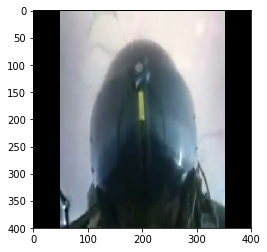

In [20]:
# display results
print(fname)
print(pred)
print(answer)
plt.imshow(img_ndarray[0])

Fuck yeah.

In [21]:
data.classes

[0, 1]

## Visualizing Performance

So it can display images and run on them correctly. I forgot to load the finetuned weights, (put them back in up above afterwards), so the base ResNet34 Learner has no idea how to match it's ImageNet weights to 2 output classes. Loading the weights and running on a few random images, I can test out if this actually works:

In [42]:
# NOTE: learner MUST be initialized before running this function
def visu_test_img():
    # grab random image
    test_dat,fpath = get_image_ndarray()
    # reinitalize dataloader & send to learner
    data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1,
                                           tfms=tfms, classes=classes, test=test_dat)
    learner.set_data(data)
    # run learner on image
    logpred,_ = learner.TTA(is_test=True)
    pred = np.mean(np.exp(logpred), 0)
    # get actual label
    folder   = fpath.split('/')[-2]
    fname    = fpath.split('/')[-1]
    answer   = labels_df.loc[labels_df['id']==folder+'/'+fname.split('.')[0]]['gloc'].values[0]
    # display results
    print(fpath, pred, answer)
    plt.figure(figsize=(5,5))
    plt.title(f'Img: {fname} Pred: {pred} Actual: {answer}')
    plt.imshow(test_dat[0])

004521.jpg                                   
[[ 0.80055  0.19945]]
1


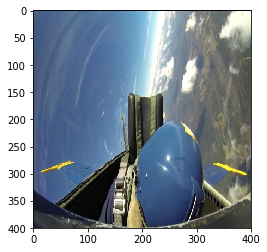

In [34]:
visu_test_img()

004592.jpg                                   
[[ 0.78709  0.21291]]
0


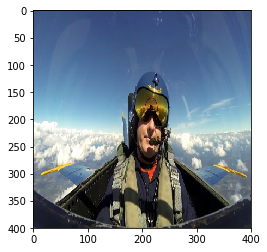

In [35]:
visu_test_img()

007156.jpg                                   
[[ 0.70425  0.29575]]
0


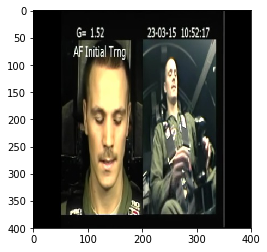

In [36]:
visu_test_img()

data/train/006549-006672/006653.jpg [[ 0.82291  0.17709]] 1
data/train/003604-003904/003736.jpg [[ 0.71529  0.28471]] 0


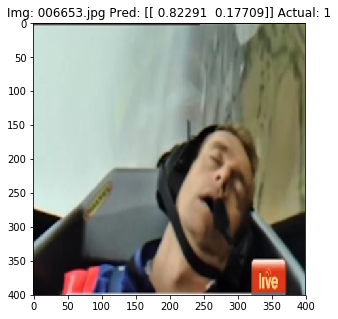

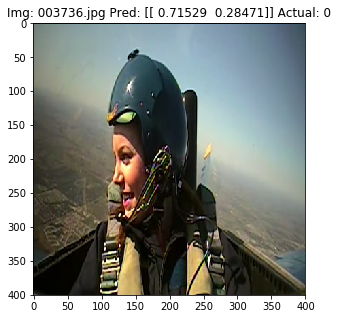

In [43]:
for i in range(2):
    visu_test_img()

Well this isn't good.. The model hasn't actually learned.

data/train/006112-006241/006131.jpg [[ 0.65381  0.34619]] 0
data/train/004402-004684/004624.jpg [[ 0.82855  0.17145]] 0
data/train/006861-007364/006892.jpg [[ 0.73297  0.26703]] 1
data/train/006440-006548/006489.jpg [[ 0.76452  0.23548]] 0
data/train/003317-003603/003354.jpg [[ 0.69273  0.30727]] 0
data/train/001190-001434/001236.jpg [[ 0.64982  0.35018]] 1
data/train/007365-007636/007470.jpg [[ 0.70867  0.29133]] 0
data/train/006673-006860/006724.jpg [[ 0.75167  0.24833]] 1
data/train/000570-001189/000753.jpg [[ 0.64625  0.35375]] 0
data/train/004685-005105/004787.jpg [[ 0.69022  0.30978]] 0
data/train/000570-001189/001114.jpg [[ 0.66658  0.33342]] 0
data/train/001190-001434/001334.jpg [[ 0.69804  0.30196]] 0
data/train/006112-006241/006225.jpg [[ 0.65899  0.34101]] 0
data/train/007365-007636/007383.jpg [[ 0.68646  0.31354]] 0
data/train/004685-005105/004823.jpg [[ 0.64488  0.35512]] 0


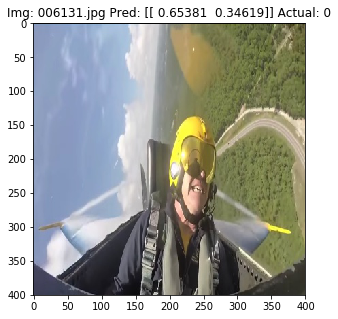

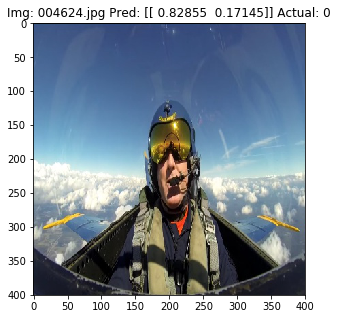

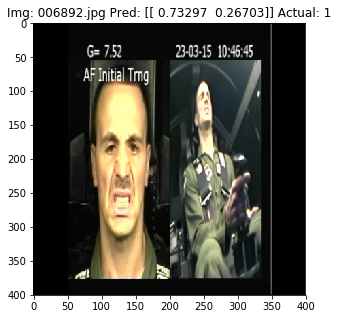

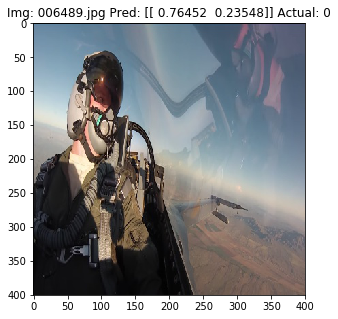

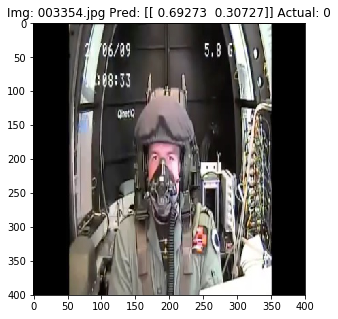

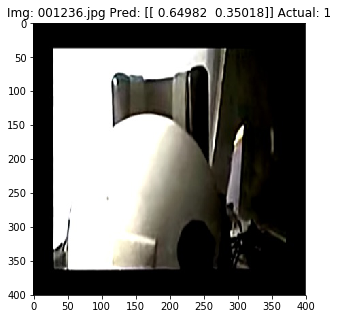

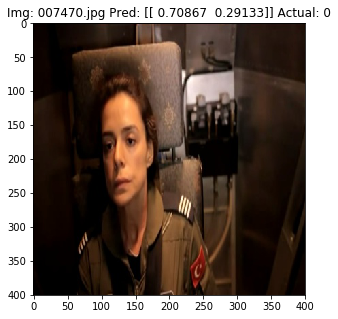

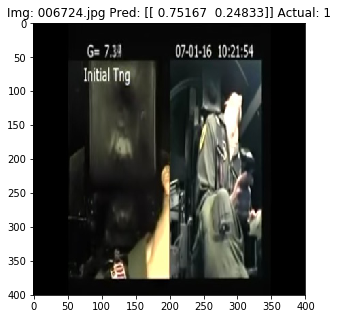

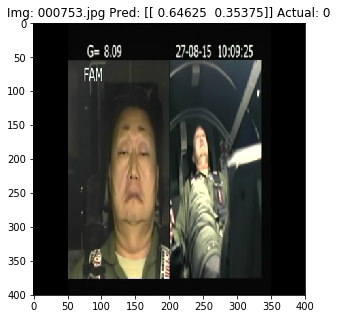

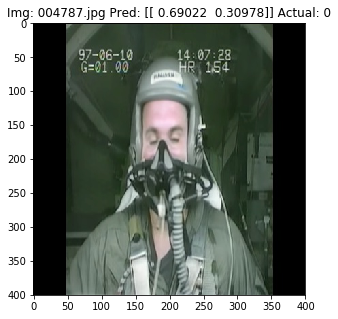

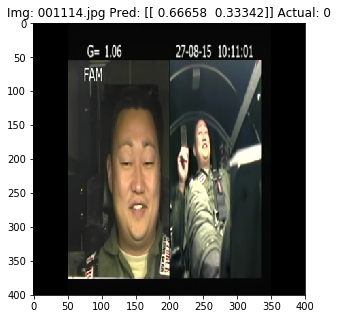

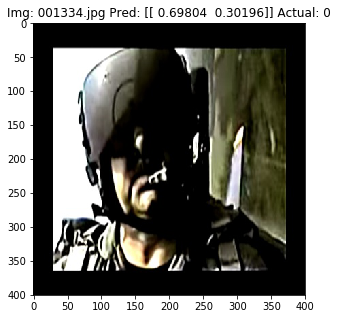

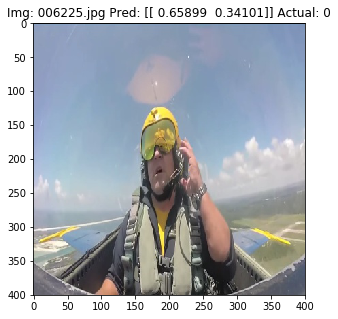

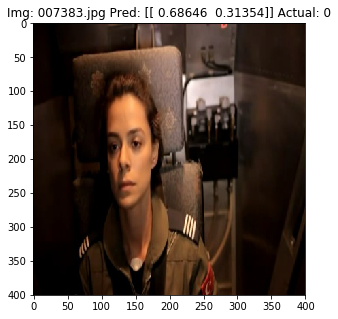

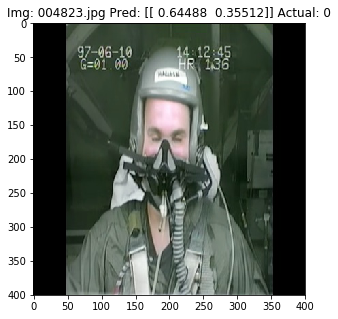

In [44]:
for i in range(15):
    visu_test_img()

## Thresholding

Attempting to find some threshold that would help increase prediction accuracy:

In [51]:
preds = [[ 0.65381,  0.34619], [ 0.82855,  0.17145], [ 0.73297,  0.26703],
         [ 0.76452,  0.23548], [ 0.69273,  0.30727], [ 0.64982,  0.35018],
         [ 0.70867,  0.29133], [ 0.75167,  0.24833], [ 0.64625,  0.35375],
         [ 0.69022,  0.30978], [ 0.66658,  0.33342], [ 0.69804,  0.30196],
         [ 0.65899,  0.34101], [ 0.68646,  0.31354], [ 0.64488,  0.35512]]
actuals = [0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
fpaths = ['data/train/006112-006241/006131.jpg',
          'data/train/004402-004684/004624.jpg',
          'data/train/006861-007364/006892.jpg',
          'data/train/006440-006548/006489.jpg',
          'data/train/003317-003603/003354.jpg',
          'data/train/001190-001434/001236.jpg',
          'data/train/007365-007636/007470.jpg',
          'data/train/006673-006860/006724.jpg',
          'data/train/000570-001189/000753.jpg',
          'data/train/004685-005105/004787.jpg',
          'data/train/000570-001189/001114.jpg',
          'data/train/001190-001434/001334.jpg',
          'data/train/006112-006241/006225.jpg',
          'data/train/007365-007636/007383.jpg',
          'data/train/004685-005105/004823.jpg']
def omg(preds=preds, actuals=actuals, threshold=0.5):
    correct = 0
    total   = len(actuals)
    for i,p in enumerate(preds):
        correct += (not p[0] < threshold) == actuals[i]
    return f'{correct}/{total}'
#     print(f'{correct}/{total}')

In [62]:
for i in range(20):
    threshold = round(1/20 * (i+1), 2)
    print(f'{threshold:.2f}: {omg(threshold=threshold)}')

0.05: 3/15
0.10: 3/15
0.15: 3/15
0.20: 3/15
0.25: 3/15
0.30: 3/15
0.35: 3/15
0.40: 3/15
0.45: 3/15
0.50: 3/15
0.55: 3/15
0.60: 3/15
0.65: 4/15
0.70: 11/15
0.75: 11/15
0.80: 11/15
0.85: 12/15
0.90: 12/15
0.95: 12/15
1.00: 12/15


Okay.. it looks like I have a lot of work to do.

Tonight, I built a way to load indiviual images into the Fast.ai arrays dataloader and run the learner on them. And it works pretty fast. After initializing the learner, the limiting factor is really how fast the computer can calculate an answer:

In [64]:
%time logpred,_ = learner.TTA(is_test=True); pred = np.mean(np.exp(logpred), 0)
# %time pred = np.mean(np.exp(logpred), 0)

CPU times: user 3.73 s, sys: 387 ms, total: 4.11 s
Wall time: 2.12 s


So, about 3.7 seconds on the processor (I checked, the `%time` function will time the entire line, not just the single logical line) for an i5 CPU MacBook Pro. That's expected.

So... In infrastructure regards.. looks like I'm doing well. I've built the parts that process, crop, and save images. I built the basic module to display them with the bounding box overlay, and I figured out how to put individual images, as I want, through the neural net to generate predictions.

The problem is those predictions are ass.

Well at least training them isn't *that* hard, once you've got all the infrastructure in place. And I'm bloody-mindedly erecting that infrastructure in place piece by piece, despite the current failings of my model (which hints bad things for the rest of my 12-model ensemble).

Okay. `00:46 - 6 Jan 2018` now. I'm calling this a day.

-- `Wayne H Nixalo`